In [1]:
import pandas as pd
import yfinance as yf

In [2]:
# Load data and calculate returns
ticker = "XLP" # XLP because Consumer staples sector show strong mean-reverting tendencies
sofr_compounded = "DE000SL0HQW9.SG"
tickers = [ticker, sofr_compounded]
period = "10y"

df = yf.download(tickers, period=period)
df = df[["Close"]].copy()
df

C:\Users\mathi\AppData\Local\Temp\ipykernel_8836\3888098632.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, period=period)
[*********************100%***********************]  2 of 2 completed


Price                Close           
Ticker     DE000SL0HQW9.SG        XLP
Date                                 
2015-07-20             NaN  38.445854
2015-07-21             NaN  38.353867
2015-07-22             NaN  38.438187
2015-07-23             NaN  38.292553
2015-07-24             NaN  38.077934
...                    ...        ...
2025-07-14     1202.670044  80.879997
2025-07-15     1202.810059  80.070000
2025-07-16     1202.959961  80.349998
2025-07-17     1203.099976  81.110001
2025-07-18     1203.250000  80.889999

[2516 rows x 2 columns]

In [3]:
# Calculate RSI
window = 14
delta = df["Close"][ticker].diff()

gain = delta.clip(lower=0)
loss = - delta.clip(upper=0)

avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

rs = avg_gain / avg_loss
df["RSI"] = 100 - (100 / (1 + rs))

df

Price                Close                   RSI
Ticker     DE000SL0HQW9.SG        XLP           
Date                                            
2015-07-20             NaN  38.445854        NaN
2015-07-21             NaN  38.353867        NaN
2015-07-22             NaN  38.438187        NaN
2015-07-23             NaN  38.292553        NaN
2015-07-24             NaN  38.077934        NaN
...                    ...        ...        ...
2025-07-14     1202.670044  80.879997  45.131057
2025-07-15     1202.810059  80.070000  39.638156
2025-07-16     1202.959961  80.349998  51.043648
2025-07-17     1203.099976  81.110001  57.885918
2025-07-18     1203.250000  80.889999  52.931001

[2516 rows x 3 columns]

In [4]:
# Define signals
import numpy as np

df["Signal"] = np.nan


df.loc[df["RSI"] < 30, "Signal"] = 1
df.loc[df["RSI"] > 80, "Signal"] = 0 # long biased to avoid premature exits in bullish trends


df["Position"] = df["Signal"].ffill().shift(1).fillna(0)

df

Price                Close                   RSI Signal Position
Ticker     DE000SL0HQW9.SG        XLP                           
Date                                                            
2015-07-20             NaN  38.445854        NaN    NaN      0.0
2015-07-21             NaN  38.353867        NaN    NaN      0.0
2015-07-22             NaN  38.438187        NaN    NaN      0.0
2015-07-23             NaN  38.292553        NaN    NaN      0.0
2015-07-24             NaN  38.077934        NaN    NaN      0.0
...                    ...        ...        ...    ...      ...
2025-07-14     1202.670044  80.879997  45.131057    NaN      1.0
2025-07-15     1202.810059  80.070000  39.638156    NaN      1.0
2025-07-16     1202.959961  80.349998  51.043648    NaN      1.0
2025-07-17     1203.099976  81.110001  57.885918    NaN      1.0
2025-07-18     1203.250000  80.889999  52.931001    NaN      1.0

[2516 rows x 5 columns]

In [5]:
# Backtest
df["Return"] = df["Close"][ticker].pct_change()
df["SOFR_Return"] = df["Close"][sofr_compounded].pct_change().fillna(0)

df.loc[df["Position"] == 0, "Strat_Return"] = df["SOFR_Return"] # Cash invested at SOFR when no position
df.loc[df["Position"] == 1, "Strat_Return"] = df["Return"]

df["Cum_Return"] = (1 + df["Return"]).cumprod() - 1
df["Cum_Strat_Return"] = (1 + df["Strat_Return"]).cumprod() - 1
df["Cum_SOFR_Return"] = (1 + df["SOFR_Return"]).cumprod() - 1


df

C:\Users\mathi\AppData\Local\Temp\ipykernel_8836\2277636982.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Return"] = df["Close"][ticker].pct_change()
C:\Users\mathi\AppData\Local\Temp\ipykernel_8836\2277636982.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["SOFR_Return"] = df["Close"][sofr_compounded].pct_change().fillna(0)


Price                Close                   RSI Signal Position    Return  \
Ticker     DE000SL0HQW9.SG        XLP                                        
Date                                                                         
2015-07-20             NaN  38.445854        NaN    NaN      0.0       NaN   
2015-07-21             NaN  38.353867        NaN    NaN      0.0 -0.002393   
2015-07-22             NaN  38.438187        NaN    NaN      0.0  0.002198   
2015-07-23             NaN  38.292553        NaN    NaN      0.0 -0.003789   
2015-07-24             NaN  38.077934        NaN    NaN      0.0 -0.005605   
...                    ...        ...        ...    ...      ...       ...   
2025-07-14     1202.670044  80.879997  45.131057    NaN      1.0  0.000866   
2025-07-15     1202.810059  80.070000  39.638156    NaN      1.0 -0.010015   
2025-07-16     1202.959961  80.349998  51.043648    NaN      1.0  0.003497   
2025-07-17     1203.099976  81.110001  57.885918    NaN      1.0  0.009459   
2025-07-18     1203.250000  80.889999  52.931001    NaN      1.0 -0.002712   

Price      SOFR_Return Strat_Return Cum_Return Cum_Strat_Return  \
Ticker                                                            
Date                                                              
2015-07-20    0.000000     0.000000        NaN         0.000000   
2015-07-21    0.000000     0.000000  -0.002393         0.000000   
2015-07-22    0.000000     0.000000  -0.000199         0.000000   
2015-07-23    0.000000     0.000000  -0.003987         0.000000   
2015-07-24    0.000000     0.000000  -0.009570         0.000000   
...                ...          ...        ...              ...   
2025-07-14    0.000358     0.000866   1.103738         1.348344   
2025-07-15    0.000116    -0.010015   1.082669         1.324826   
2025-07-16    0.000125     0.003497   1.089952         1.332956   
2025-07-17    0.000116     0.009459   1.109720         1.355022   
2025-07-18    0.000125    -0.002712   1.103998         1.348635   

Price      Cum_SOFR_Return  
Ticker                      
Date                        
2015-07-20         0.00000  
2015-07-21         0.00000  
2015-07-22         0.00000  
2015-07-23         0.00000  
2015-07-24         0.00000  
...                    ...  
2025-07-14         0.20261  
2025-07-15         0.20275  
2025-07-16         0.20290  
2025-07-17         0.20304  
2025-07-18         0.20319  

[2516 rows x 11 columns]

[]

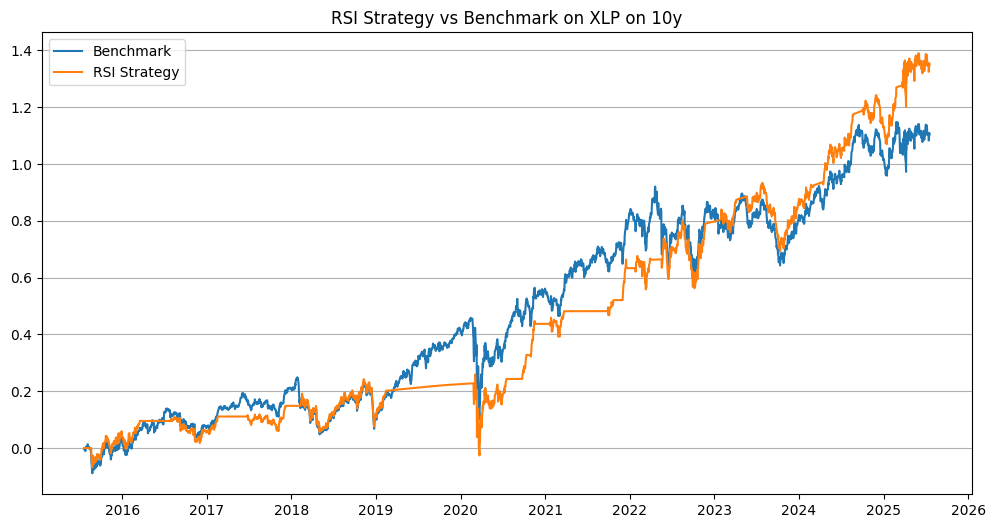

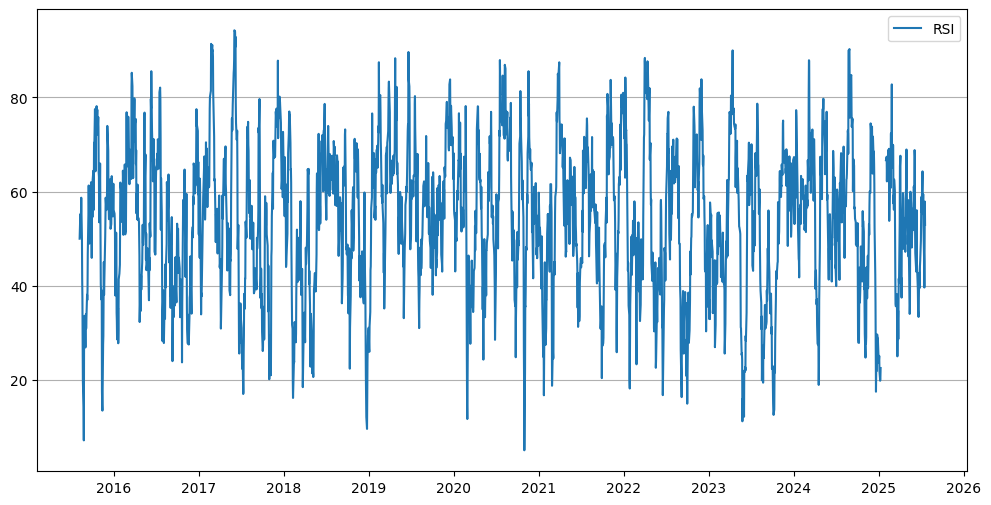

In [6]:
# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df["Cum_Return"], label= "Benchmark")
plt.plot(df["Cum_Strat_Return"], label= "RSI Strategy")
plt.title(f"RSI Strategy vs Benchmark on {ticker} on {period}")
plt.legend()
plt.grid(True,axis="y")
plt.plot()

# Plot RSI
plt.figure(figsize=(12,6))
plt.plot(df["RSI"], label= "RSI")
plt.legend()
plt.grid(True,axis="y")
plt.plot()


In [7]:
### Statistics ###

# Calculate RSI strategy metrics
cumulated_return_strat = df["Cum_Strat_Return"].iloc[-1]
cumulated_return_sofr = df["Cum_SOFR_Return"].iloc[-1]
ann_return_strat = (1 + cumulated_return_strat) ** (252 / len(df)) - 1
ann_return_sofr = (1 + cumulated_return_sofr) ** (252 / len(df)) - 1

vol_strat = df["Strat_Return"].std() * (252 ** 0.5)
downside_vol_strat = df[df["Strat_Return"] < 0]["Strat_Return"].std() * (252 ** 0.5)
sharpe_strat = (ann_return_strat - ann_return_sofr) / vol_strat
sortino_strat = (ann_return_strat - ann_return_sofr) / downside_vol_strat

roll_max = df["Cum_Strat_Return"].cummax()
daily_dd_strat = df["Cum_Strat_Return"] - roll_max
max_dd_strat = daily_dd_strat.min()
calmar_strat = ann_return_strat / abs(max_dd_strat)

# Calculate Benchmark metrics
cumulated_return_benchmark = df["Cum_Return"].iloc[-1]
ann_return_benchmark = (1 + cumulated_return_benchmark) ** (252 / len(df)) - 1

vol_benchmark = df["Return"].std() * (252 ** 0.5)
downside_vol_benchmark = df[df["Return"] < 0]["Return"].std() * (252 ** 0.5)
sharpe_benchmark = (ann_return_benchmark - ann_return_sofr) / vol_benchmark
sortino_benchmark = (ann_return_benchmark - ann_return_sofr) / downside_vol_benchmark

roll_max_benchmark = df["Cum_Return"].cummax()
daily_dd_benchmark = df["Cum_Return"] - roll_max_benchmark
max_dd_benchmark = daily_dd_benchmark.min()
calmar_benchmark = ann_return_benchmark / abs(max_dd_benchmark)

# Print RSI strategy metrics
print("RSI Strategy Metrics:")
print(f"Cumulated return: {cumulated_return_strat:.2%}")
print(f"Annualized return: {ann_return_strat:.2%}")
print(f"Volatility: {vol_strat:.2%}")
print(f"Sharpe ratio: {sharpe_strat:.2f}")
print(f"Sortino ratio: {sortino_strat:.2f}")
print(f"Max Drawdown: {max_dd_strat:.2%}")
print(f"Calmar ratio: {calmar_strat:.2f}")

# Print benchmark strategy metrics
print("\nBenchmark Metrics:")
print(f"Cumulated return: {cumulated_return_benchmark:.2%}")
print(f"Annualized return: {ann_return_benchmark:.2%}")
print(f"Volatility: {vol_benchmark:.2%}")
print(f"Sharpe ratio: {sharpe_benchmark:.2f}")
print(f"Sortino ratio: {sortino_benchmark:.2f}")
print(f"Max Drawdown: {max_dd_benchmark:.2%}")
print(f"Calmar ratio: {calmar_benchmark:.2f}")

RSI Strategy Metrics:
Cumulated return: 134.86%
Annualized return: 8.93%
Volatility: 13.03%
Sharpe ratio: 0.54
Sortino ratio: 0.56
Max Drawdown: -28.50%
Calmar ratio: 0.31

Benchmark Metrics:
Cumulated return: 110.40%
Annualized return: 7.73%
Volatility: 14.86%
Sharpe ratio: 0.39
Sortino ratio: 0.50
Max Drawdown: -35.76%
Calmar ratio: 0.22
